## LeNet-5
LeNet-5를 사용하는 예제를 구현해 봅시다. 우리가 구현할 신경망은 다음 그림과 같습니다.

![](../Static/247.jpg)

32x32 크기의 이미지에 합성곱층과 최대 풀링층이 쌍으로 두 번 적용된 후 완전연결층을 거쳐 이미지가 분류되는 신경망입니다.

신경망에 대한 자세한 설명은 다음 표와 같습니다.

|계층 유형|특성 맵|크기|커널 크기|스트라이드|활성화 함수|
|---|---|---|---|---|---|
|이미지|1|32x32|-|-|-|
|합성곱층|6|28x28|5x5|1|렐루|
|최대 풀링층|6|14x14|2x2|2|-|
|합성곱층|16|10x10|5x5|1|렐루|
|최대 풀링층|16|5x5|2x2|2|-|
|완전연결층|-|120|-|-|렐루|
|완전연결층|-|84|-|-|렐루|
|완전연결층|-|2|-|-|소프트맥스|

예제를 진행하기 위해 프롬프트에서 `tqdm` 라이브러리를 설치해 주세요. 라이브러리는 다음과 같이 두 가지 방법으로 설치할 수 있습니다.

> pip install tqdm

> conda install -c conda-forge tqdm

tqdm은 아랍어로 progress(진행 상태)라고도 합니다. 즉, 진행 상태를 바(bar) 형태로 가시화하여 보여 줍니다. 주로 `모델 훈련에 대한 진행 상태`를 확인하고자 할 때 사용합니다.

설치가 완료되었다면 필요한 라이브러리를 호출합니다.

In [2]:
import torch
import torchvision

from torch.utils.data import dataset, DataLoader
import torchvision.transforms as transforms # 이미지 변환(전처리) 기능을 제공하는 라이브러리
import torchvision.datasets as datasets
from torch.autograd import Variable
import torch.optim as optim

import torch.nn as nn
import torch.nn.functional as F

import os
import cv2

from PIL import Image
from tqdm import tqdm_notebook as tqdm # 진행 상황을 가시적으로 표현

import random
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


먼저 모델 학습에 필요한 데이터셋의 전처리(텐서 변환)이 필요합니다.

In [3]:
train_data_dir = './seg_train/seg_train'
test_data_dir = './seg_test/seg_test'
batch_size = 32

transform = transforms.Compose(
    [transforms.Resize(64),
     transforms.CenterCrop(64),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True)])

train_dataset = datasets.ImageFolder(train_data_dir,
                                     transform=transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size,
                                               shuffle=True,
                                               drop_last=True)

test_dataset = datasets.ImageFolder(test_data_dir,
                                    transform=transform)

test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=batch_size,
                                              shuffle=False,
                                              drop_last=True)


* `토치비전(torchvision)` 라이브러리를 이용하면 이미지에 대한 전처리를 손쉽게 할 수 있습니다. `torchvision.transforms` 에서 사용하는 파라미터는 다음과 같습니다.
    * `transforms.Compose` 이미지를 변형할 수 있는 방식들의 묶음입니다.
    * `transforms.RandomResizedCrop` 입력 이미지를 주어진크기(resize:224x224)로 조정합니다. 또한, `scale`은 원래 이미지를 임의의 크기(0.5~1.0) 만큼 면적을 무작위로 자르겠다는 의미입니다.
    * `transforms.RandomHorizontalFlip` 주어진 확률로 이미지를 수평 반전시킵니다. 이때 확률 값을 지정하지 않았으므로 기본값인 0.5의 확률로 이미지들이 수평 반전됩ㄴ다. 즉, 훈련 이미지 중 반은 위아래 뒤집한 상태로 두고, 반은 그대로 사용합니다.
    * `transforms.ToTensor()` ImageFolder 메서드를 비롯해서 torchvision 메서드는 이미지를 읽을 때 파이썬 이미지 라이브러리인 PIL을 사용합니다. PIL을 사용해서 이미지를 읽으면 생성되는 이미지는 범위가 [0,255]이며, 배열의 차원이 `(높이 H x 너비 W x 채널 수 C)`로 표현됩니다. 이후 효율적인 연산을 위해 `torch.FloatTensor` 배열로 바꾸어야 하는데, 이때 픽셀 값의 범위는 [0.0, 1.0] 사이가 되고 차원의 순서도 `(채널 수 C x 높이 H x 너비 W)`로 바뀝니다. 그리고 이러한 작업을 수행해 주는 메서드가 `ToTensor()`입니다.
    * `transforms.Normalize` 전이 학습에서 사용되는 사전 훈련된 모델들은 대게 `ImageNet 데이터셋`에서 훈련되었습니다. 따라서 사전 훈련된 모델을 사용하기 위해서는 ImageNet 데이터의 각 채널별 평균과 표준편차에 맞는 `정규화(Normalize)`를 해 주어야 합니다. 참고로 openCV를 사용해서 이미지를 읽어 온다면 RGB이미지가 아닌 BGR 이미지이므로 채널 순서에 주의해야 합니다.

* `__call__` 함수는 클래스를 호출할 수 있도록 하는 메서드입니다. __init__은 인스턴스 초기화를 위해 사용한다면 __call__은 인스턴스가 호출되었을 때 실행됩니다. 즉, 클래스에 __call__ 함수가 있을 경우 클래스 객체 자체를 호출하면 __call__함수의 리턴(return) 값이 반환됩니다.

이미지가 위치한 디렉터리에서 불러옵니다.

Number of samples:  32
Image Size:  torch.Size([32, 3, 64, 64])
tensor([5, 3, 4, 5, 3, 4, 2, 4, 0, 2, 4, 0, 1, 3, 1, 5, 1, 4, 4, 2, 3, 0, 4, 2,
        5, 4, 2, 5, 4, 5, 0, 3])


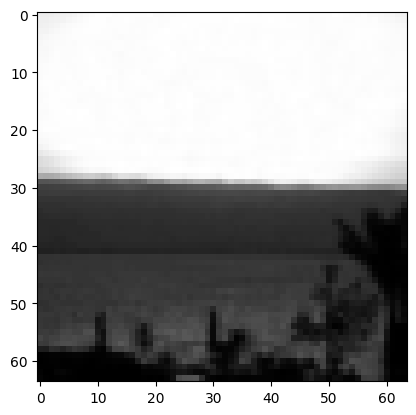

In [4]:
images, labels = next(iter(train_dataloader))

print('Number of samples: ', len(images))

image = images[2][0]
plt.imshow(image, cmap='gray')

print("Image Size: ", images.shape)

print(labels)


이제 데이터셋을 학습시킬 모델의 네트워크를 설계하기 위한 클래스를 생성합니다.

In [15]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=64, kernel_size=3, padding=1, stride=1)
        # 파라미터 수 : (kernel_size *2) * in_c * out_c + out_c
        self.conv2 = nn.Conv2d(
            in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1)
        # 파라미터 수 : (kernel_size *2) * in_c * out_c + out_c
        self.conv3 = nn.Conv2d(
            in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1)
        # 파라미터 수 : (kernel_size *2) * in_c * out_c + out_c
        self.conv4 = nn.Conv2d(
            in_channels=256, out_channels=512, kernel_size=3, padding=1, stride=1)
        # 파라미터 수 : (kernel_size *2) * in_c * out_c + out_c

        self.pool = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(in_features=512 * 4 * 4, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=6)
        # 파라미터 수 : in_f * out_f + out_f

        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class CNN_MK2(nn.Module):
    def __init__(self):
        super(CNN_MK2, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,64,3,padding=1,stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc1 = nn.Linear(512 * 4 * 4, 128)
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(128, 6)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out


In [16]:
model = CNN().to(device=device)
print(model)

modelMK2 = CNN_MK2().to(device)
print(modelMK2)


CNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)
CNN_MK2(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Se

출력 결과가 한눈에 들어오지 않는다면 `torchsummary` 라이브러리를 사용해 볼 수 있습니다. `torchsummary`는 케라스와 같은 형태로 모델을 출력해 볼 수 있는 라이브러리입니다.

먼저 라이브러리를 설치합니다.
> pip install torchsummary

설치가 완료되었다면 torchsummary 라이브러리를 사용하여 모델의 네트워크 구조를 다시 확인해 봅시다.

In [17]:
from torchsummary import summary

summary(model, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
         MaxPool2d-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 32, 32]          73,856
         MaxPool2d-4          [-1, 128, 16, 16]               0
            Conv2d-5          [-1, 256, 16, 16]         295,168
         MaxPool2d-6            [-1, 256, 8, 8]               0
            Conv2d-7            [-1, 512, 8, 8]       1,180,160
         MaxPool2d-8            [-1, 512, 4, 4]               0
            Linear-9                  [-1, 128]       1,048,704
          Dropout-10                  [-1, 128]               0
           Linear-11                    [-1, 6]             774
Total params: 2,600,454
Trainable params: 2,600,454
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forw

In [18]:
from torchsummary import summary

summary(modelMK2, input_size=(3, 64, 64))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
              ReLU-2           [-1, 64, 64, 64]               0
         MaxPool2d-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,856
              ReLU-5          [-1, 128, 32, 32]               0
         MaxPool2d-6          [-1, 128, 16, 16]               0
            Conv2d-7          [-1, 256, 16, 16]         295,168
              ReLU-8          [-1, 256, 16, 16]               0
         MaxPool2d-9            [-1, 256, 8, 8]               0
           Conv2d-10            [-1, 512, 8, 8]       1,180,160
             ReLU-11            [-1, 512, 8, 8]               0
        MaxPool2d-12            [-1, 512, 4, 4]               0
           Linear-13                  [-1, 128]       1,048,704
          Dropout-14                  [

In [24]:
def fit(epochs, model, criterion, optimizer, device=device, dataloader=train_dataloader):

    for e in range(epochs):
        running_loss = 0
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.data
        else:
            print(f" Epoch {e}, Training loss: {running_loss/len(dataloader)}")


In [28]:
epochs = 10
model = CNN().to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

fit(epochs, model, criterion, optimizer)


 Epoch 0, Training loss: 1.2665506601333618
 Epoch 1, Training loss: 0.9253822565078735
 Epoch 2, Training loss: 0.7735886573791504
 Epoch 3, Training loss: 0.6715831160545349
 Epoch 4, Training loss: 0.5863961577415466
 Epoch 5, Training loss: 0.5069655179977417
 Epoch 6, Training loss: 0.4486648142337799
 Epoch 7, Training loss: 0.39137211441993713
 Epoch 8, Training loss: 0.3335861265659332
 Epoch 9, Training loss: 0.28163942694664


In [29]:
def predict(model, batch_size=32, device=device, dataloader=test_dataloader):
    classes = ('buildings', 'forest', 'glacier', 'mountain',
               'sea', 'street')

    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        n_class_correct = [0 for i in range(6)]
        n_class_samples = [0 for i in range(6)]
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()

            for i in range(batch_size):
                label = labels[i]
                pred = predicted[i]
                if (label == pred):
                    n_class_correct[label] += 1
                n_class_samples[label] += 1

        acc = 100.0 * n_correct / n_samples
        print(f'Accuracy of the network: {acc} %')

        for i in range(6):
            acc = 100.0 * n_class_correct[i] / n_class_samples[i]
            print(f'Accuracy of {classes[i]}: {acc} %')


In [30]:
predict(model)


Accuracy of the network: 79.80510752688173 %
Accuracy of buildings: 79.40503432494279 %
Accuracy of forest: 81.64556962025317 %
Accuracy of glacier: 72.15189873417721 %
Accuracy of mountain: 71.80952380952381 %
Accuracy of sea: 89.6078431372549 %
Accuracy of street: 85.53459119496856 %


In [1]:
import torch
import torch.nn as nn

# define input tensor
input_tensor = torch.randn(1, 3, 32, 32)

# define convolutional layer
conv_layer = nn.Conv2d(in_channels=3, out_channels=32,
                       kernel_size=3, stride=1, padding=1)

# pass input tensor through the convolutional layer
output_tensor = conv_layer(input_tensor)

# check the size of the output tensor
print(output_tensor.shape)


c:\Users\aqs45\OneDrive\바탕 화면\repo\Learn_pytorch\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([1, 32, 32, 32])
